# Cab-Driver Agent - RL Case Study
## Submitted by:Riddhi Tokdar

# **Problem Statement:**
Propose a method based on reinforcement learning to optimize taxi driving strategies for profit maximization.Create the environment and an RL agent that learns to choose the best request.

In [4]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Environment import CabDriver

#### Defining Time Matrix

In [15]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
Time_matrix.shape

(5, 5, 24, 7)

#### Tracking the state-action pairs for checking convergence


In [16]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open('/content/drive/MyDrive/RL_Output_DQN/'+name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [17]:
#states to check
import collections
states_track = collections.defaultdict(dict)
def initialise_tracking_states():
    sample_q_values = [((0,5,1),[(2,3)]),((2,2,2),[(1,2)]),((2,7,4),[(3,4)]),((0,18,3),[(1,4)])]#select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        for i in q_values[1]:
            action = i
            states_track[state][action] = []

In [18]:
#initialisation
initialise_tracking_states() 

In [19]:
print(states_track)


defaultdict(<class 'dict'>, {(0, 5, 1): {(2, 3): []}, (2, 2, 2): {(1, 2): []}, (2, 7, 4): {(3, 4): []}, (0, 18, 3): {(1, 4): []}})


In [20]:
#save tracking states
def save_tracking_states():
    for state in states_track.keys():
        for action in states_track[state].keys():
            state_encod = env.state_encod_arch1(state)
            state_encod = np.reshape(state_encod, [1, agent.state_size])
            prediction = agent.model.predict(state_encod)
            
            action_index = env.action_space.index(action)
            
            Q = prediction[0][action_index]
            
            states_track[state][action].append(Q) 

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [42]:
#Defining the agent class
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate =  0.01      
        self.epsilon_max = 1
        
        #self.epsilon_decay = 0.00035#for 20 k episode
        self.epsilon_decay = 0.02 #for 2k episodes
        self.epsilon_min = 0.00000001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        
        

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32,activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model

    def get_action(self, state, episode):
        # Write your code here:
        # Decay in ε after we generate each sample from the environment       
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)

        # Get the requests for the current cab driver state
        possible_actions_index,actions = env.requests(state)

        # get action from model using epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            
            return random.choice(possible_actions_index)
        
        else:
            encoded_state = env.state_encod_arch1(state)
            state_value = np.array(encoded_state).reshape(1, self.state_size)
            q_value = self.model.predict(state_value)

            q_value = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_value)]


    def append_sample(self, state, action, reward, next_state, terminal_state):
       
        self.memory.append((state, action, reward, next_state, terminal_state))
   
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > 100:  #100 instead of batch size to speed up training
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            #Initialize input of output
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, terminal_states = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal_state = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                update_output[i] = env.state_encod_arch1(next_state)
                actions.append(action)
                rewards.append(reward)
                terminal_states.append(terminal_state)
                
                
            # 2. Get the target for the Q-network Q(s',a)
            target = self.model.predict(update_input)
              
            
            target_qval = self.model.predict(update_output)
                
          
            for i in range(self.batch_size):
                if terminal_states[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state 
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
   
    #save model
    def save(self, name):
        with open('/content/drive/MyDrive/RL_Output_DQN/'+name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)
    

    #this would save as .h5 format
    def save_h5(self, name):
        self.model.save('/content/drive/MyDrive/RL_Output_DQN/'+name)

In [43]:
Episodes = 2000#lowering for faster code else 15-20 k episodes
episode_time=720 #30 days before which car has to be recharged
rewards_per_episode, episodes = [], []
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()


# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)


#initialize the DQN agent
agent = DQNAgent(action_size=action_size, state_size=state_size)    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                1184      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 21)                693       
                                                                 
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [44]:
#env.action_space

### DQN block

In [45]:
#env.state_space

In [48]:


for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    
    # reset at the start of each episode
    # Call all the initialised variables of the environment
    action_size ,state_size,state =  env.reset()
    
    terminal_state = False
    score = 0
    total_time = 0    
    
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state, episode)
        
        # 2. Evaluate your reward and next state
        #next_state,terminal_state  = env.next_state_func(state, action, Time_matrix)
        #reward = env.reward_func(state, action, Time_matrix)
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        total_time += step_time
        
        if(total_time >= episode_time):
            # if battery has to be recharged we have recached terminal state
            terminal_state = True
        else:
            # 3. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, terminal_state)
        
            # 4. Train the model by calling function agent.train_model
            agent.train_model()
        
            # 5. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state
    
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # every 10 episodes:
    if (episode==0):
        print("episode: {0}, reward: {1}, memory_length: {2}, epsilon: {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon))
    if ((episode + 1) % 10 == 0):
        print("episode: {0}, reward: {1}, memory_length: {2}, epsilon: {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon))
    
    if (episode+1) % 50 == 0:   #every 2000th episode
        print('-------saving states to track---------')   
        save_tracking_states()
        save_obj(states_track,'States_tracked')
        print('--------completed states track step--------') 
        
    if ((episode + 1) % 100 == 0):
        
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
        agent.save_h5(name='Model_Cab_Driver.h5')
        
        print("----completed model save------")

        



episode: 0, reward: -113.0, memory_length: 2000, epsilon: 1.0
episode: 9, reward: 51.0, memory_length: 2000, epsilon: 0.8352702130585699
episode: 19, reward: -210.0, memory_length: 2000, epsilon: 0.6838614123737418
episode: 29, reward: 170.0, memory_length: 2000, epsilon: 0.5598983709664184
episode: 39, reward: 444.0, memory_length: 2000, epsilon: 0.4584060167211634
episode: 49, reward: 673.0, memory_length: 2000, epsilon: 0.3753111050982886
-------saving states to track---------
--------completed states track step--------
episode: 59, reward: 776.0, memory_length: 2000, epsilon: 0.30727874552834383
episode: 69, reward: 697.0, memory_length: 2000, epsilon: 0.25157856054397093
episode: 79, reward: 807.0, memory_length: 2000, epsilon: 0.20597510614513245
episode: 89, reward: 817.0, memory_length: 2000, epsilon: 0.168638155582214
episode: 99, reward: 834.0, memory_length: 2000, epsilon: 0.13806924593020042
-------saving states to track---------
--------completed states track step--------


In [51]:
#save rewards
save_obj(rewards_per_episode, 'rewards_per_episode')

In [58]:
#save states
save_obj(states_track,'States_track_dqn')#already saved earlier 

### Tracking Convergence

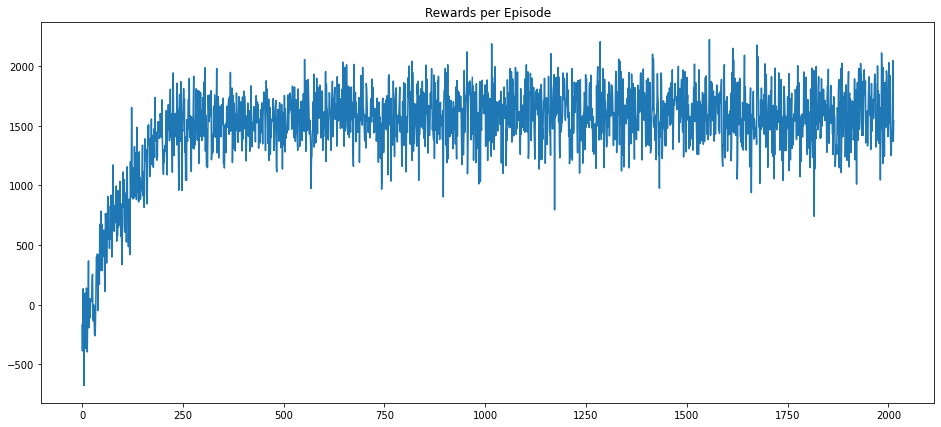

In [52]:
#Load the rewards and plot the results
with open('/content/drive/MyDrive/RL_Output_DQN/rewards_per_episode.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

xaxis = np.asarray(range(0, len(rewards_per_episode)))
plt.figure(0, figsize=(16,7))
plt.title("Rewards per Episode")
plt.plot(xaxis,np.asarray(rewards_per_episode))
plt.show()

In [53]:
# Load the q values of state action pairs
with open('/content/drive/MyDrive/RL_Output_DQN/States_tracked.pkl', 'rb') as f:
    States_track = pickle.load(f)


(0, 5, 1)


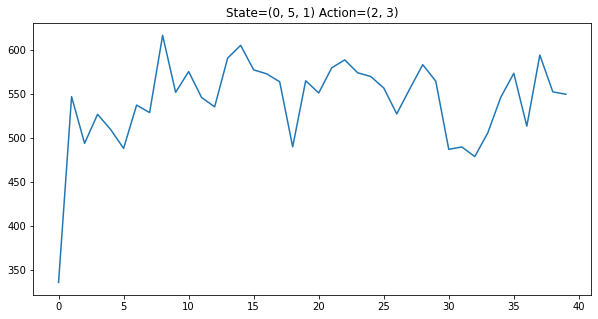

(2, 2, 2)


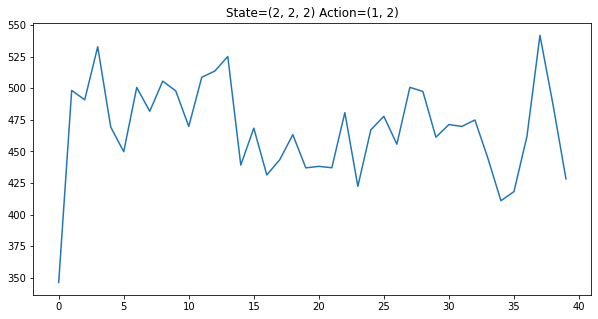

(2, 7, 4)


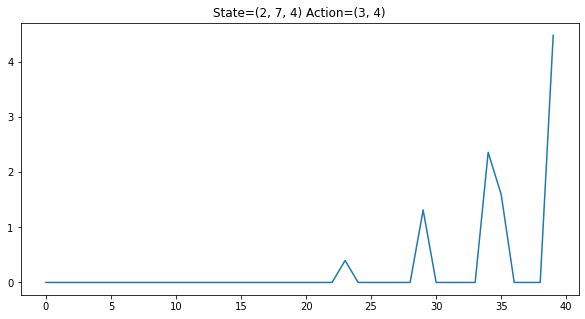

(0, 18, 3)


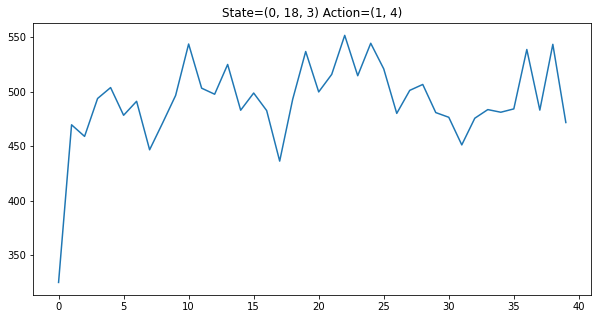

In [57]:
# Plot the results - state_action
for s in States_track.keys():
    print(s)
    for k in States_track[s].keys():
        #print(k)
        plt.figure(figsize=(10,5))
        #print('\n')
        x_axis = np.asarray(range(0, len(States_track[s][k])))
        plt.title("State={a} Action={b}".format(a=s,b=k))
        plt.plot(x_axis,np.asarray(States_track[s][k]))
        plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [13]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0.00000001 + (1 - 0.00000001) * np.exp(-0.0035*i))

In [40]:
#for 2k episodes
time = np.arange(0,2000)
epsilon = []
for i in range(0,2000):
    epsilon.append(0.00000001 + (1 - 0.00000001) * np.exp(-0.01*i))

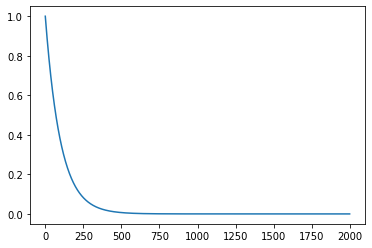

In [41]:
plt.plot(time, epsilon)
plt.show()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
